# Bayesian Optimization

[Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is used to solve an optimization problem
$$ x^* = \text{argmin} \ f(x), $$
where $f$ is an unknown objective function which
+ hard to compute,
+ has no derivative,
+ observations of $f$ contain noise.

An optimization process includes constructing a sequence of points $\{x_n\}$ which converges to $x^*$. However, due to the above restrictions, it is hard to construct such sequence using information directly from $f$. In Bayesian Optimization, we put a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) prior on $f$ and derive from it an "acquisition" function $\alpha(x)$ which is easy to evaluate and get derivatives (hence optimizing $\alpha(x)$ is easy). This "acquisition" function encodes the following information for $f$: its minimum is a candidate for $x_n$.

Each time we get more information from $f$, the Gaussian Process model will be updated (similar to the way we update posteriors in Bayesian models) and the derived "acquisition" function will reflect more information about $x^*$. After a number of steps, it is likely that $\{x_n\}$ will converge to the minimum point of $f$.

In this tutorial, we will see how to use the Gaussian Process module in Pyro to do Bayesian Optimization.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
from pyro.contrib.gp.kernels import Matern32
from pyro.contrib.gp.models import GPRegression
from pyro.optim import Adam
pyro.set_rng_seed(0)

## Define a problem

The objective function we are going to solve is
$$f(x) = \frac{x^2}{10} + \sin(x), \quad x\in [-10, 10].$$

In [2]:
def f(x):
    return x**2 / 10 + torch.sin(x)

The minimizer of $f$ is $-1.30644$. Let's take a plot for $x$.

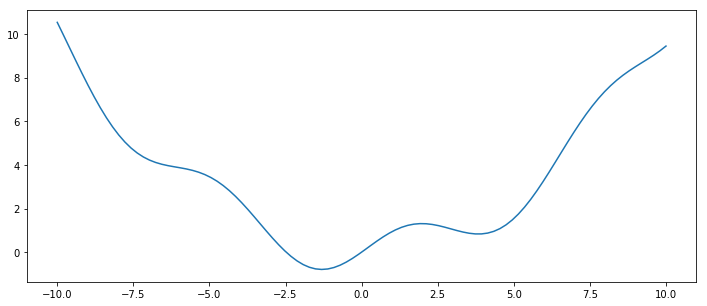

In [3]:
x = torch.linspace(-10, 10)
plt.figure(figsize=(12, 5))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

## Define an acquisition function

We will use the acquisition Lower Confidence Bound (see reference [1]). Its definition is
$$
\alpha(x) = \mu(x) - 2 \sigma(x),
$$
where $\mu$ and $\sigma$ are mean and variance of Gaussian Process posterior.

In [5]:
X = torch.linspace(-11, 11, 3)
y = f(X)
gpmodel = GPRegression(X, y, Matern32(1), torch.Tensor([0.01]))
gpmodel.fix_param("noise")
constraint = constraints.interval(-10, 10)
acquisition = LowerConfidenceBound(gpmodel, constraint=constraint)

We make a convenient function to plot the results.

In [6]:
def plot(acquisition, xmin):
    Xnew = torch.linspace(-10, 10)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acquisition.model.X.numpy(), acquisition.model.y.numpy(), "kx")
    with torch.no_grad():
        loc, var = acquisition.model(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)
        plt.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)
    plt.xlim(-10, 10)
    plt.ylabel("Gaussian Process Regression")

    plt.subplot(2, 1, 2)
    with torch.no_grad():
        plt.plot(Xnew.numpy(), acquisition(Xnew).numpy())
        plt.plot(xmin.numpy(), acquisition(xmin).numpy(), "^", markersize=10,
                 label="next x = {:.5f}".format(xmin.item()))
    plt.xlim(-10, 10)
    plt.ylabel("Lower Confidence Bound")
    plt.legend()
    plt.show()

### Find $\{x_n\}$

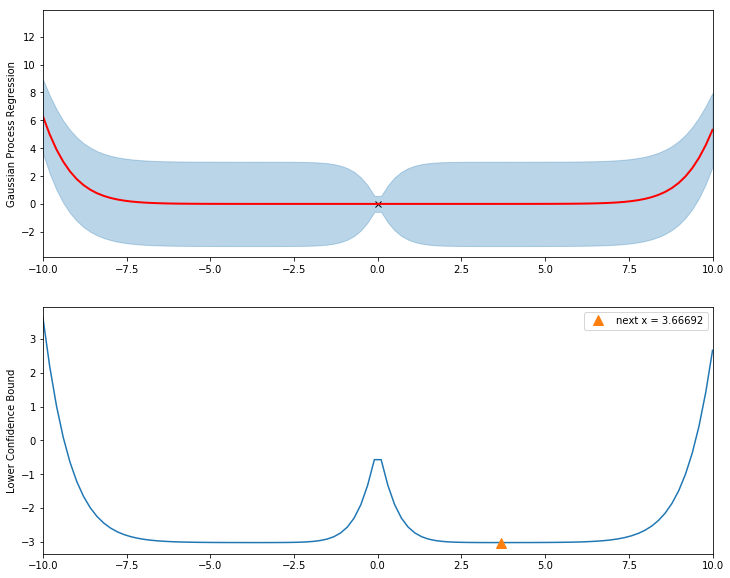

In [7]:
acquisition.model.optimize(Adam({}))
x1 = acquisition.minimum()
plot(acquisition, x1)

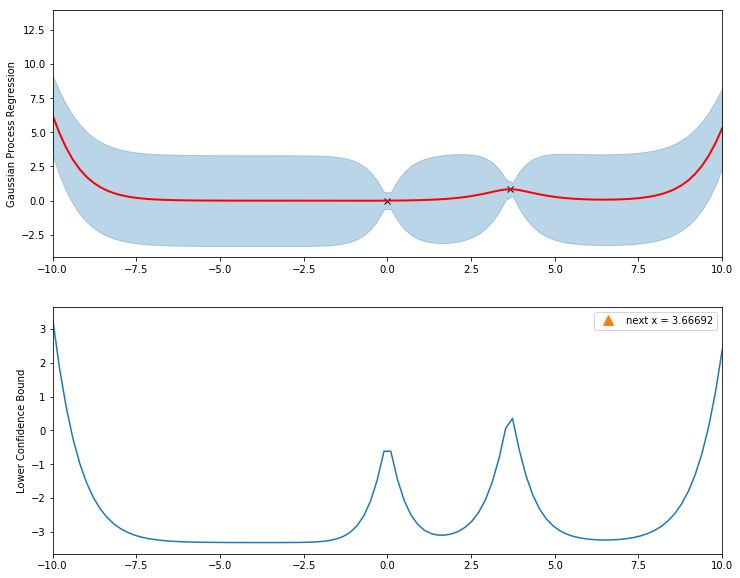

In [8]:
acquisition.update_data(x1, objective=f)
x2 = acquisition.minimum()
plot(acquisition, x2)

In [9]:
acquisition.update_data(x2, objective=f)
x3 = acquisition.minimum()
plot(acquisition, x3)

RuntimeError: Lapack Error in potrf : the leading minor of order 5 is not positive definite at /home/fehiepsi/pytorch/aten/src/TH/generic/THTensorLapack.c:617

In [ ]:
acquisition.update_data(x3, objective=f)
x4 = acquisition.minimum()
plot(acquisition, x4)

In [ ]:
acquisition.update_data(x4, objective=f)
x5 = acquisition.minimum()
plot(acquisition, x5)

In [ ]:
acquisition.update_data(x5, objective=f)
x6 = acquisition.minimum()
plot(acquisition, x6)

In [ ]:
acquisition.update_data(x6, objective=f)
x7 = acquisition.minimum()
plot(acquisition, x7)

In [ ]:
acquisition.update_data(x7, objective=f)
x8 = acquisition.minimum()
plot(acquisition, x8)

In [ ]:
acquisition.update_data(x8, objective=f)
x9 = acquisition.minimum()
plot(acquisition, x9)

At this point, we can see that the acquisition can not find its global minimum. This is a drawback of gradient descent methods.

In [ ]:
acquisition.update_data(x9, objective=f)
x10 = acquisition.minimum()
plot(acquisition, x10)

Now, we run 10 more steps.

In [ ]:
x = x10
for i in range(11, 21):
    acquisition.update_data(x, objective=f)
    x = acquisition.minimum()
plot(acquisition, x)

We can see that the sequence converges to the minimum $−1.30644$ but cannot get there. The reason is that we assume our observation has noise!

## References

[1] `Practical bayesian optimization of machine learning algorithms`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Jasper Snoek, Hugo Larochelle, and Ryan P. Adams